In [ ]:
# !pip install xgboost

     -------------------------------------- 150.0/150.0 MB 7.0 MB/s eta 0:00:00


In [ ]:
# !pip install shap

     ------------------------------------- 489.6/489.6 kB 10.2 MB/s eta 0:00:00


In [ ]:
# ! pip install optuna

     -------------------------------------- 386.6/386.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
# !pip install -U kaleido

     --------------------------------------- 65.9/65.9 MB 16.0 MB/s eta 0:00:00


In [ ]:
# !pip install lightgbm

     ---------------------------------------- 1.5/1.5 MB 15.3 MB/s eta 0:00:00


In [ ]:
# !pip install --upgrade xgboost lightgbm pandas scikit-learn dask distributed

In [ ]:
# conda install -c conda-forge xgboost lightgbm dask distributed scikit-learn pandas

^C

Note: you may need to restart the kernel to use updated packages.


## Modelo lightGBM

 - Seleção de variáveis somente considerando as variáveis que não são scores
 - Scores de outras empresas geralmente são muito caros, e sendo visando a redução de custo ou para avaliar um modelo sem esssa variáveis é sempre interessante fazer um modelo base para comparação.

## 00.Pacotes

In [ ]:
import pandas as pd
import numpy as np
import funcoes_basicas as funcs
import funcoes_derivadas as funcs_deriv
import random
import gc

import matplotlib.pyplot as plt
import itertools

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve

from lightgbm import LGBMClassifier
import lightgbm as lgb

# Filter out the ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning

from datetime import date, datetime
from tqdm import tqdm
from scipy.stats import ks_2samp

import xgboost as xgb
import optuna
import pickle
import shap

from joblib import dump, load

def ks_stat(y, y_pred):
    return ks_2samp(y_pred[y == 1], y_pred[y != 1]).statistic

ks_score = make_scorer(ks_stat)

# Definindo a semente
random.seed(123)

import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 01. Baixando a base

In [ ]:
# Baixando os dados de treino
df_treino = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_treino_processado.parquet',
                                 engine='pyarrow')

df_treino.head()

,SK_ID_CURR,TARGET_publico,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__INCOME_TO_BIRTH_RATIO_publico,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico
0,100010,0,0.540654,0.714279,-999.000000,0.03,1530000.0,-449.0,-18850.0,-999.0,...,-19.10,-999.0,-999.0,0.0,0.0,0.0,-999.0,1.0,0.0,1.0
1,100263,0,0.270707,0.235314,0.770814,0.06,585000.0,365243.0,-23456.0,133240.5,...,-4.60,-999.0,-999.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,100320,0,-999.000000,0.610447,-999.000000,0.10,463500.0,-2907.0,-11996.0,-999.0,...,-18.76,-999.0,-999.0,0.0,0.0,-999.0,0.0,1.0,0.0,0.0
3,100704,0,0.621226,0.398296,0.676170,0.03,760500.0,-7042.0,-17781.0,29682.0,...,-5.06,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,1.0
4,100768,0,0.556727,0.639849,0.722559,0.04,229500.0,-2271.0,-20438.0,-999.0,...,-5.50,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,0.0


In [ ]:
# Baixando os dados de teste
df_teste = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_teste_processado.parquet',
                                 engine='pyarrow')
df_teste.head()

,SK_ID_CURR,TARGET_publico,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__INCOME_TO_BIRTH_RATIO_publico,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico
0,101122,0,0.605836,0.347977,-999.000000,0.04,517500.0,-2058.0,-12198.0,-999.0,...,-7.38,-999.0000,-999.0,0.0,1.0,-999.0,0.0,0.0,0.0,0.0
1,102745,0,0.357293,0.591461,0.336847,0.04,607500.0,-2024.0,-17131.0,313573.5,...,-11.82,-999.0000,-999.0,0.0,0.0,-999.0,0.0,0.0,0.0,1.0
2,103634,0,0.584990,0.707927,-999.000000,0.03,1125000.0,-3391.0,-17445.0,-999.0,...,-16.77,-999.0000,-999.0,0.0,0.0,-999.0,0.0,0.0,0.0,1.0
3,104454,0,0.519097,-999.000000,-999.000000,0.11,58500.0,-5093.0,-13772.0,0.0,...,-7.35,0.0154,-999.0,0.0,0.0,-999.0,0.0,0.0,0.0,0.0
4,104665,0,0.495666,0.303363,0.285083,0.05,900000.0,-191.0,-9269.0,-999.0,...,-19.42,0.1026,-999.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0


In [ ]:
# Substiruir o nome da coluna do target

df_treino = df_treino.rename(columns={"TARGET_publico": "TARGET"})
df_teste = df_teste.rename(columns={"TARGET_publico": "TARGET"})

## 02. Concatenando os dados de treino e teste

In [ ]:
# Adiciona a coluna 'periodo' em cada DataFrame
df_treino['periodo'] = 'treino'
df_teste['periodo'] = 'teste'

# Concatena os dois
df_final_marcado = pd.concat([df_treino, df_teste], ignore_index=True)
df_final_marcado.shape

(184350, 44)

In [ ]:
df_final_marcado.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico,periodo
0,100010,0,0.540654,0.714279,-999.000000,0.03,1530000.0,-449.0,-18850.0,-999.0,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,1.0,0.0,1.0,treino
1,100263,0,0.270707,0.235314,0.770814,0.06,585000.0,365243.0,-23456.0,133240.5,...,-999.0,-999.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,treino
2,100320,0,-999.000000,0.610447,-999.000000,0.10,463500.0,-2907.0,-11996.0,-999.0,...,-999.0,-999.0,0.0,0.0,-999.0,0.0,1.0,0.0,0.0,treino
3,100704,0,0.621226,0.398296,0.676170,0.03,760500.0,-7042.0,-17781.0,29682.0,...,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,1.0,treino
4,100768,0,0.556727,0.639849,0.722559,0.04,229500.0,-2271.0,-20438.0,-999.0,...,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,0.0,treino


In [ ]:
# Verificando duplicados
df_final_marcado[df_final_marcado.duplicated(subset='SK_ID_CURR', keep=False)]

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico,periodo


In [ ]:
# Verificando a volumetria do Target (Bad Rate)
contagem = df_final_marcado['TARGET'].value_counts()
percentual = df_final_marcado['TARGET'].value_counts(normalize=True) * 100

df_resultado = pd.DataFrame({'Total': contagem, 'Porcentagem': round(percentual, 2)})
df_resultado


,Total,Porcentagem
TARGET,,
0,170074,92.26
1,14276,7.74


In [ ]:
df_final_marcado.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'num__EXT_SOURCE_3_publico',
 'num__EXT_SOURCE_2_publico',
 'num__EXT_SOURCE_1_publico',
 'num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__VL_TOT_VL_TOT_AM

In [ ]:
# Removendo as variáveis de Score

df_final_marcado = df_final_marcado[[
 'SK_ID_CURR',
 'TARGET',
 'num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__TOTALAREA_MODE_publico',
 'num__REGION_POPULATION_RELATIVE_publico',
 'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
 'num__DAYS_ID_PUBLISH_publico',
 'num__CAR_TO_EMPLOYED_RATIO_publico',
 'num__REG_CITY_NOT_WORK_CITY_publico',
 'num__FLAG_DOCUMENT_3_publico',
 'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__DAYS_REGISTRATION_publico',
 'cat__OCCUPATION_TYPE_publico_Laborers',
 'num__INCOME_TO_BIRTH_RATIO_publico',
 'num__LIVINGAPARTMENTS_MEDI_publico',
 'num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo',
 'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
 'cat__WALLSMATERIAL_MODE_publico_Panel',
 'num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo',
 'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
 'cat__NAME_CONTRACT_TYPE_publico_Cash_loans',
 'num__FLAG_DOCUMENT_6_publico',
 'num__FLAG_WORK_PHONE_publico',
 'periodo']]

df_final_marcado.head()

,SK_ID_CURR,TARGET,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo,...,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico,periodo
0,100010,0,0.03,1530000.0,-449.0,-18850.0,-999.0,1.00,-801.780029,-999.00,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,1.0,0.0,1.0,treino
1,100263,0,0.06,585000.0,365243.0,-23456.0,133240.5,1.00,0.300000,133240.50,...,-999.0,-999.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,treino
2,100320,0,0.10,463500.0,-2907.0,-11996.0,-999.0,1.04,-77.400002,-999.00,...,-999.0,-999.0,0.0,0.0,-999.0,0.0,1.0,0.0,0.0,treino
3,100704,0,0.03,760500.0,-7042.0,-17781.0,29682.0,1.00,-12.780000,524198.25,...,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,1.0,treino
4,100768,0,0.04,229500.0,-2271.0,-20438.0,-999.0,1.21,-49.540001,-999.00,...,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,0.0,treino


## 03. Seleção de variáveis

### 03.01. Ajustando o formato das variáveis

In [ ]:
# Separando as variáveis por tipo: categórica, numérica e algumas que possam ter erro
# tirando as 2 primeiras variáveis 'SK_ID_CURR' e 'TARGET'
## Ajustando o formato das variáveis
vars = df_final_marcado.columns[2:-1].tolist()

lista_vars_num = []
lista_vars_categ = []
lista_vars_erro = []

for var in vars:
    tipo_coluna = df_final_marcado[var].dtype
    if tipo_coluna.name in (['Int32', 'Int64', 'int32', 'int64', 'Float32', 'Float64', 'float32', 'float64']):
        lista_vars_num.append(var)
    elif tipo_coluna.name in (['object', 'string', 'category']):
        lista_vars_categ.append(var)
    else:
        lista_vars_erro.append(var)

print(f'lista_vars_num: {len(lista_vars_num)}')
print()
print(f'lista_vars_categ: {len(lista_vars_categ)}')
print()
print(f'lista_vars_erro: {len(lista_vars_erro)}')


lista_vars_num: 38

lista_vars_categ: 0

lista_vars_erro: 0


In [ ]:
vars_lista = df_final_marcado.columns.tolist()
vars_lista

['SK_ID_CURR',
 'TARGET',
 'num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__TOTALAREA_MODE_publico',
 'num__REG

In [ ]:
vars_pre_sel = [
 'num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__TOTALAREA_MODE_publico',
 'num__REGION_POPULATION_RELATIVE_publico',
 'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
 'num__DAYS_ID_PUBLISH_publico',
 'num__CAR_TO_EMPLOYED_RATIO_publico',
 'num__REG_CITY_NOT_WORK_CITY_publico',
 'num__FLAG_DOCUMENT_3_publico',
 'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__DAYS_REGISTRATION_publico',
 'cat__OCCUPATION_TYPE_publico_Laborers',
 'num__INCOME_TO_BIRTH_RATIO_publico',
 'num__LIVINGAPARTMENTS_MEDI_publico',
 'num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo',
 'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
 'cat__WALLSMATERIAL_MODE_publico_Panel',
 'num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo',
 'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
 'cat__NAME_CONTRACT_TYPE_publico_Cash_loans',
 'num__FLAG_DOCUMENT_6_publico',
 'num__FLAG_WORK_PHONE_publico']

### 03.02. Univariada¶

In [ ]:
## Calcula a univariada das variáveis já considerando a imputação de missing = -999

univariada_v2 = funcs.univariada_numerica_v2(df_final_marcado, vars_pre_sel)
univariada_v2.to_excel('univariada_lightgbm_sem_score.xlsx')

### 03.03. Calculando o IV e KS

In [ ]:
# Calcula IV e KS

tabela_iv_ks, tabela_iv_ks_completa = funcs.calcular_iv_ks_woe(
    dados=df_final_marcado,
    variaveis=vars_pre_sel,
    target='TARGET',
    chave='SK_ID_CURR',
    bins=10,
    exibir_woe=False,
    ordenacao=['IV', 'KS']
)

tabela_iv_ks

Calculando IV/KS/WOE: 100%|████████████████████████████████████████████████████████████| 38/38 [00:19<00:00,  1.90it/s]


,Variavel,IV,KS
0,num__PAYMENT_RATE_publico,0.105,0.096
1,num__AMT_GOODS_PRICE_publico,0.100,0.092
2,num__DAYS_EMPLOYED_publico,0.098,0.083
3,num__DAYS_BIRTH_publico,0.082,0.117
4,num__CREDIT_TO_GOODS_RATIO_publico,0.077,0.122
5,num__INCOME_TO_EMPLOYED_RATIO_publico,0.076,0.122
6,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS...,0.075,0.132
7,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS...,0.065,0.117
8,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_...,0.058,0.112
9,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_...,0.058,0.109


In [ ]:
# Filtrando as variáveis com valore de IV >= 0.01
tabela_iv_ks_filtrado = tabela_iv_ks[
    (tabela_iv_ks['Variavel'].isin(vars_pre_sel)) & (tabela_iv_ks['IV'] >= 0.01)
].reset_index(drop=True)

tabela_iv_ks_filtrado

,Variavel,IV,KS
0,num__PAYMENT_RATE_publico,0.105,0.096
1,num__AMT_GOODS_PRICE_publico,0.100,0.092
2,num__DAYS_EMPLOYED_publico,0.098,0.083
3,num__DAYS_BIRTH_publico,0.082,0.117
4,num__CREDIT_TO_GOODS_RATIO_publico,0.077,0.122
5,num__INCOME_TO_EMPLOYED_RATIO_publico,0.076,0.122
6,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS...,0.075,0.132
7,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS...,0.065,0.117
8,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_...,0.058,0.112
9,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_...,0.058,0.109


In [ ]:
vars_selecionadas = tabela_iv_ks_filtrado['Variavel'].tolist()

print(len(vars_selecionadas))

vars_selecionadas

36


['num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__DAYS_ID_PUBLISH_publico',
 'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
 'num__CAR_TO_EMPLOYED_RAT

In [ ]:
vars_selecionadas =[
 'num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__DAYS_ID_PUBLISH_publico',
 'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
 'num__CAR_TO_EMPLOYED_RATIO_publico',
 'num__TOTALAREA_MODE_publico',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__REGION_POPULATION_RELATIVE_publico',
 'num__REG_CITY_NOT_WORK_CITY_publico',
 'num__FLAG_DOCUMENT_3_publico',
 'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__DAYS_REGISTRATION_publico',
 'cat__OCCUPATION_TYPE_publico_Laborers',
 'num__INCOME_TO_BIRTH_RATIO_publico',
 'num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo',
 'cat__WALLSMATERIAL_MODE_publico_Panel',
 'num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo',
 'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
 'num__LIVINGAPARTMENTS_MEDI_publico',
 'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
 'num__FLAG_DOCUMENT_6_publico']

## 04. Teste inicial de parâmetros para o modelo LightGBM

In [ ]:
# Separação dos dados de treino e teste para entrar no modelo

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][vars_selecionadas]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][vars_selecionadas]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = LGBMClassifier(
        n_jobs=3,
        objective='binary',
        metric = 'auc',
        tree_learner = 'serial',
        boosting_type = 'gbdt',
        random_state=42,
        categorical_feature = [],
        #missing = np.nan,
        verbosity = -10,
        is_unbalace = True,

        **{'learning_rate': 0.1550000000000000,
           'n_estimators': 101,
           'max_depth': 3,
           'reg_alpha':4.21,
           'reg_lambda': 72.9100000000001,
           'num_leaves': 42,
           'colsample_bytree': 0.55,
           'subsample': 0.8,
           'subsample_freq': 2,
           'min_child_samples': 7719,
           'max_bin': 88,
           'min_data_in_bin': 805,
           'scale_pos_weght': 1.4}
        ).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% _ AUC Teste: {100.0*auc_test:.2f}% _ KS Treino: {100.0*ks_train:.2f}% _ KS Teste: {100.0*ks_test:.2f}%')

# AUC Treino: 71.97% _ AUC Teste: 70.54% _ KS Treino: 32.36% _ KS Teste: 31.11%

AUC Treino: 71.97% _ AUC Teste: 70.54% _ KS Treino: 32.36% _ KS Teste: 31.11%


### 04.01. Feature Importance

In [ ]:
importancias = pd.DataFrame({
        'variavel': vars_selecionadas,
        'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)

importancias['%importancia'] = importancias['importancia']/importancias['importancia'].sum()
importancias

,variavel,importancia,%importancia
0,num__AMT_GOODS_PRICE_publico,43,0.091880
1,num__CREDIT_TO_GOODS_RATIO_publico,33,0.070513
2,num__PAYMENT_RATE_publico,31,0.066239
3,num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS...,28,0.059829
4,num__DAYS_ID_PUBLISH_publico,24,0.051282
5,num__DAYS_BIRTH_publico,22,0.047009
6,num__REGION_POPULATION_RELATIVE_publico,21,0.044872
7,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_M...,20,0.042735
8,num__DAYS_LAST_PHONE_CHANGE_publico,17,0.036325
9,num__DAYS_EMPLOYED_publico,16,0.034188


In [ ]:
X_test.isnull().sum().sum()

0

### 05. Otimizando o modelo LightGBM

In [ ]:
# # === Dados ===
# X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][vars_selecionadas]
# y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

# X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][vars_selecionadas]
# y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


# # === Função de avaliação ===
# def custom_loss(**params):
#     model = LGBMClassifier(
#         n_jobs=3,
#         objective='binary',
#         metric = 'auc',
#         tree_learner = 'serial',
#         boosting_type = 'gbdt',
#         random_state=42,
#         categorical_feature = [],
#         #missing = np.nan,
#         verbosity = -10,
#         is_unbalace = True,
#         **params
#     ).fit(X_train, y_train)

#     score_train = model.predict_proba(X_train)[:, 1]
#     score_test = model.predict_proba(X_test)[:, 1]

#     auc_train = roc_auc_score(y_train, score_train)
#     auc_test = roc_auc_score(y_test, score_test)
#     ks_train = funcs.ks_score_v2(y_train, score_train)
#     ks_test = funcs.ks_score_v2(y_test, score_test)

#     auc_diff = abs(auc_train - auc_test)
#     ks_diff = abs(ks_train - ks_test)

#     return auc_diff + ks_diff, auc_test  # objetivo 1: minimizar overfit, objetivo 2: maximizar performance

# # === Função objetivo Optuna ===
# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 1, step=0.05),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 130),
#         'max_depth': trial.suggest_int('max_depth', 2, 5),
#         'reg_alpha': trial.suggest_float('alpha', 0.01, 40, step=0.1),
#         'reg_lambda': trial.suggest_float('lambda', 30, 80, step=0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 3, 100),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1, step=0.05),
#         'subsample': trial.suggest_float('subsample', 0.05, 1, step=0.05),
#         'subsample_freq': trial.suggest_int('subsample_freq', 1, 15),
#         'min_child_samples': trial.suggest_int('min_child_samples', 6000, 9000),
#         'max_bin': trial.suggest_int('max_bin', 30, 100),
#         'min_data_in_bin': trial.suggest_int ('min_data_in_bin', 5, 2**10),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20, step=0.2),
#         'force_col_wise': True,
#     }
#     return custom_loss(**params)

In [ ]:
# # === Criando ou carregando o estudo ===
# create = True
# if create:
#     sampler = optuna.samplers.NSGAIISampler(population_size=50)
#     otimizacao = optuna.create_study(
#         directions=['minimize', 'maximize'],  # (overfitting, auc_teste)
#         sampler=sampler
#     )
# else:
#     with open('otimizacao_lighgbm_blend4.pkl', 'rb') as arquivo:
#         otimizacao = pickle.load(arquivo)

In [ ]:
# # === Rodando a otimização ===
# for i in range(50):
#     trials = len(otimizacao.trials)
#     if trials >= 500:
#         break

#     if trials > 0:
#         try:
#             best_diff = max(
#                 [(trial.values[0], trial.values[1]) for trial in otimizacao.trials if trial.values and trial.values[0] < .03],
#                 key=lambda x: x[1]
#             )
#         except ValueError:
#             best_diff = (0, 0)
#     else:
#         best_diff = (0, 0)

#     print(f'# Trials: {trials} - Melhor AUC: {100 * best_diff[1]:.2f}% - Overfit (AUC+KS Diff): {100 * best_diff[0]:.2f}%')

#     otimizacao.optimize(objective, n_trials=min(500 - trials, 10))

#     with open('otimizacao_lighgbm_blend4.pkl', 'wb') as arquivo:
#         pickle.dump(otimizacao, arquivo)

#     # === Gráfico de Pareto ===
#     fig = optuna.visualization.plot_pareto_front(
#         otimizacao,
#         target_names=['AUC+KS Diff', 'AUC Teste']
#     )
#     fig.write_html('otimizacao_lighgbm_blend4.html')

# Trials: 0 - Melhor AUC: 0.00% - Overfit (AUC+KS Diff): 0.00%
# Trials: 10 - Melhor AUC: 67.32% - Overfit (AUC+KS Diff): 1.65%
# Trials: 20 - Melhor AUC: 67.32% - Overfit (AUC+KS Diff): 1.65%
# Trials: 30 - Melhor AUC: 68.95% - Overfit (AUC+KS Diff): 2.88%
# Trials: 40 - Melhor AUC: 70.50% - Overfit (AUC+KS Diff): 1.03%
# Trials: 50 - Melhor AUC: 70.50% - Overfit (AUC+KS Diff): 1.03%
# Trials: 60 - Melhor AUC: 70.73% - Overfit (AUC+KS Diff): 2.02%
# Trials: 70 - Melhor AUC: 70.73% - Overfit (AUC+KS Diff): 2.02%
# Trials: 80 - Melhor AUC: 70.73% - Overfit (AUC+KS Diff): 2.02%
# Trials: 90 - Melhor AUC: 70.73% - Overfit (AUC+KS Diff): 2.02%
# Trials: 100 - Melhor AUC: 70.73% - Overfit (AUC+KS Diff): 2.02%
# Trials: 110 - Melhor AUC: 70.73% - Overfit (AUC+KS Diff): 2.02%
# Trials: 120 - Melhor AUC: 70.86% - Overfit (AUC+KS Diff): 2.25%
# Trials: 130 - Melhor AUC: 70.86% - Overfit (AUC+KS Diff): 2.25%
# Trials: 140 - Melhor AUC: 70.86% - Overfit (AUC+KS Diff): 2.25%
# Trials: 150 - Melhor

### 05.01. Selecionando e testando as trials

In [ ]:
# ## Lendo as Trials

# with open('otimizacao_lighgbm_blend4.pkl', 'rb') as arquivo3:
#         otimizacao = pickle.load(arquivo3)

In [ ]:
# #Selecionando as trials pelo gráfico de pareto (otimizacao_lightgbm.html)
# otimizacao.trials[452].params

{'learning_rate': 0.255,
 'n_estimators': 121,
 'max_depth': 4,
 'alpha': 12.01,
 'lambda': 68.4,
 'num_leaves': 32,
 'colsample_bytree': 0.05,
 'subsample': 0.8,
 'subsample_freq': 6,
 'min_child_samples': 6937,
 'max_bin': 100,
 'min_data_in_bin': 170,
 'scale_pos_weight': 8.600000000000001}

In [ ]:
# Testando os parâmetros selecionados

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][vars_selecionadas]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][vars_selecionadas]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = model = LGBMClassifier(
        n_jobs=3,
        objective='binary',
        metric = 'auc',
        tree_learner = 'serial',
        boosting_type = 'gbdt',
        random_state=42,
        categorical_feature = [],
        #missing = np.nan,
        verbosity = -10,
        is_unbalace = True,

        **{'learning_rate': 0.255,
 'n_estimators': 121,
 'max_depth': 4,
 'alpha': 12.01,
 'lambda': 68.4,
 'num_leaves': 32,
 'colsample_bytree': 0.05,
 'subsample': 0.8,
 'subsample_freq': 6,
 'min_child_samples': 6937,
 'max_bin': 100,
 'min_data_in_bin': 170,
 'scale_pos_weight': 8.600000000000001}
        ).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% | AUC Teste: {100.0*auc_test:.2f}% | KS Treino: {100.0*ks_train:.2f}% | KS Teste: {100.0*ks_test:.2f}%')


# otimizacao_lighgbm_blend4.pkl:
#trial 431: AUC Treino: 70.66% | AUC Teste: 69.94% | KS Treino: 30.50% | KS Teste: 30.49%
#trial 459: AUC Treino: 71.60% | AUC Teste: 70.68% | KS Treino: 31.98% | KS Teste: 32.01%
#trial 410: AUC Treino: 71.88% | AUC Teste: 70.74% | KS Treino: 32.33% | KS Teste: 31.67%
#trial 452: AUC Treino: 72.00% | AUC Teste: 70.87% | KS Treino: 32.64% | KS Teste: 31.71%

AUC Treino: 72.00% | AUC Teste: 70.87% | KS Treino: 32.64% | KS Teste: 31.71%


In [ ]:
importancias = pd.DataFrame({
        'variavel': vars_selecionadas,
        'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)

importancias['%importancia'] = importancias['importancia']/importancias['importancia'].sum()
importancias

,variavel,importancia,%importancia
0,num__DAYS_EMPLOYED_publico,57,0.075000
1,num__REGION_POPULATION_RELATIVE_publico,57,0.075000
2,num__PAYMENT_RATE_publico,56,0.073684
3,num__DAYS_REGISTRATION_publico,55,0.072368
4,num__CREDIT_TO_GOODS_RATIO_publico,52,0.068421
5,num__INCOME_TO_BIRTH_RATIO_publico,49,0.064474
6,num__TOTALAREA_MODE_publico,44,0.057895
7,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_M...,43,0.056579
8,num__DAYS_BIRTH_publico,29,0.038158
9,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_...,27,0.035526


## Modelo Final

In [ ]:
# Variáveis Finais

variaveis_finalistas = importancias[importancias['%importancia'] > 0.01].variavel.tolist()

len(variaveis_finalistas), variaveis_finalistas

(24,
 ['num__DAYS_EMPLOYED_publico',
  'num__REGION_POPULATION_RELATIVE_publico',
  'num__PAYMENT_RATE_publico',
  'num__DAYS_REGISTRATION_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__INCOME_TO_BIRTH_RATIO_publico',
  'num__TOTALAREA_MODE_publico',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__DAYS_BIRTH_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__AMT_GOODS_PRICE_publico',
  'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__DAYS_ID_PUBLISH_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__FLAG_DOCUMENT_3_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__INCOME_

In [ ]:
variaveis_finalistas = [
  'num__DAYS_EMPLOYED_publico',
  'num__REGION_POPULATION_RELATIVE_publico',
  'num__PAYMENT_RATE_publico',
  'num__DAYS_REGISTRATION_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__INCOME_TO_BIRTH_RATIO_publico',
  'num__TOTALAREA_MODE_publico',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__DAYS_BIRTH_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__AMT_GOODS_PRICE_publico',
  'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__DAYS_ID_PUBLISH_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__FLAG_DOCUMENT_3_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'cat__NAME_INCOME_TYPE_publico_Working',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'num__CAR_TO_EMPLOYED_RATIO_publico'
]

In [ ]:
# Modelo final

# Separação dos dados de treino e teste para entrar no modelo

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][variaveis_finalistas]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][variaveis_finalistas]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = model = LGBMClassifier(
        n_jobs=3,
        objective='binary',
        metric = 'auc',
        tree_learner = 'serial',
        boosting_type = 'gbdt',
        random_state=42,
        categorical_feature = [],
        #missing = np.nan,
        verbosity = -10,
        is_unbalace = True,

        **{'learning_rate': 0.255,
 'n_estimators': 121,
 'max_depth': 4,
 'alpha': 12.01,
 'lambda': 68.4,
 'num_leaves': 32,
 'colsample_bytree': 0.05,
 'subsample': 0.8,
 'subsample_freq': 6,
 'min_child_samples': 6937,
 'max_bin': 100,
 'min_data_in_bin': 170,
 'scale_pos_weight': 8.600000000000001}
        ).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% | AUC Teste: {100.0*auc_test:.2f}% | KS Treino: {100.0*ks_train:.2f}% | KS Teste: {100.0*ks_test:.2f}%')

# otimizacao_lighgbm_blend4.pkl:
# trial: AUC Treino: 69.61% | AUC Teste: 69.14% | KS Treino: 28.75% | KS Teste: 28.92%

#AUC Treino: 70.31% | AUC Teste: 69.42% | KS Treino: 30.11% | KS Teste: 28.83%

#AUC Treino: 70.63% | AUC Teste: 69.64% | KS Treino: 30.44% | KS Teste: 29.66%

#AUC Treino: 70.88% | AUC Teste: 70.12% | KS Treino: 30.83% | KS Teste: 30.49%

AUC Treino: 70.88% | AUC Teste: 70.12% | KS Treino: 30.83% | KS Teste: 30.49%


In [ ]:
importancias = pd.DataFrame({
        'variavel': variaveis_finalistas,
        'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)

importancias['%importancia'] = importancias['importancia']/importancias['importancia'].sum()
importancias

,variavel,importancia,%importancia
0,num__INCOME_TO_BIRTH_RATIO_publico,58,0.087613
1,num__AMT_GOODS_PRICE_publico,57,0.086103
2,num__DAYS_ID_PUBLISH_publico,48,0.072508
3,num__CREDIT_TO_GOODS_RATIO_publico,48,0.072508
4,num__DAYS_REGISTRATION_publico,47,0.070997
5,num__DAYS_LAST_PHONE_CHANGE_publico,47,0.070997
6,num__DAYS_BIRTH_publico,46,0.069486
7,num__DAYS_EMPLOYED_publico,40,0.060423
8,num__REGION_POPULATION_RELATIVE_publico,38,0.057402
9,num__INCOME_TO_EMPLOYED_RATIO_publico,37,0.055891


In [ ]:
# Filtrando importância menor do que zero

variaveis_finalistas2 = importancias[importancias['%importancia'] > 0.01].variavel.tolist()

len(variaveis_finalistas2), variaveis_finalistas2

(21,
 ['num__INCOME_TO_BIRTH_RATIO_publico',
  'num__AMT_GOODS_PRICE_publico',
  'num__DAYS_ID_PUBLISH_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__DAYS_REGISTRATION_publico',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__DAYS_BIRTH_publico',
  'num__DAYS_EMPLOYED_publico',
  'num__REGION_POPULATION_RELATIVE_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__PAYMENT_RATE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__TOTALAREA_MODE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_ex

In [ ]:
variaveis_finalistas2 = ['num__INCOME_TO_BIRTH_RATIO_publico',
  'num__AMT_GOODS_PRICE_publico',
  'num__DAYS_ID_PUBLISH_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__DAYS_REGISTRATION_publico',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__DAYS_BIRTH_publico',
  'num__DAYS_EMPLOYED_publico',
  'num__REGION_POPULATION_RELATIVE_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__PAYMENT_RATE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__TOTALAREA_MODE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo']

In [ ]:
# Modelo final

# Separação dos dados de treino e teste para entrar no modelo

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][variaveis_finalistas2]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][variaveis_finalistas2]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = LGBMClassifier(
        n_jobs=3,
        objective='binary',
        metric = 'auc',
        tree_learner = 'serial',
        boosting_type = 'gbdt',
        random_state=42,
        categorical_feature = [],
        #missing = np.nan,
        verbosity = -10,
        is_unbalace = True,

        **{'learning_rate': 0.255,
 'n_estimators': 121,
 'max_depth': 4,
 'alpha': 12.01,
 'lambda': 68.4,
 'num_leaves': 32,
 'colsample_bytree': 0.05,
 'subsample': 0.8,
 'subsample_freq': 6,
 'min_child_samples': 6937,
 'max_bin': 100,
 'min_data_in_bin': 170,
 'scale_pos_weight': 8.600000000000001}
        ).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% | AUC Teste: {100.0*auc_test:.2f}% | KS Treino: {100.0*ks_train:.2f}% | KS Teste: {100.0*ks_test:.2f}%')

# otimizacao_lighgbm_blend4.pkl:
# trial: AUC Treino: 69.61% | AUC Teste: 69.14% | KS Treino: 28.75% | KS Teste: 28.92%

#AUC Treino: 70.31% | AUC Teste: 69.42% | KS Treino: 30.11% | KS Teste: 28.83%

#AUC Treino: 70.63% | AUC Teste: 69.64% | KS Treino: 30.44% | KS Teste: 29.66%

#AUC Treino: 70.88% | AUC Teste: 70.12% | KS Treino: 30.83% | KS Teste: 30.49%

# AUC Treino: 70.72% | AUC Teste: 69.85% | KS Treino: 30.50% | KS Teste: 30.54%

AUC Treino: 70.72% | AUC Teste: 69.85% | KS Treino: 30.50% | KS Teste: 30.54%


In [ ]:
importancias = pd.DataFrame({
        'variavel': variaveis_finalistas2,
        'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)

importancias['%importancia'] = importancias['importancia']/importancias['importancia'].sum()
importancias

,variavel,importancia,%importancia
0,num__DAYS_REGISTRATION_publico,54,0.078488
1,num__AMT_GOODS_PRICE_publico,53,0.077035
2,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS...,49,0.071221
3,num__DAYS_BIRTH_publico,45,0.065407
4,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS...,45,0.065407
5,num__PAYMENT_RATE_publico,44,0.063953
6,num__DAYS_EMPLOYED_publico,43,0.062500
7,num__INCOME_TO_EMPLOYED_RATIO_publico,43,0.062500
8,num__REGION_POPULATION_RELATIVE_publico,39,0.056686
9,num__CREDIT_TO_GOODS_RATIO_publico,32,0.046512


In [ ]:
# Filtrando importância menor do que zero

variaveis_finais_ord_import = importancias[importancias['%importancia'] > 0.01].variavel.tolist()

len(variaveis_finais_ord_import), variaveis_finais_ord_import

(21,
 ['num__DAYS_REGISTRATION_publico',
  'num__AMT_GOODS_PRICE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__DAYS_BIRTH_publico',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__PAYMENT_RATE_publico',
  'num__DAYS_EMPLOYED_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__REGION_POPULATION_RELATIVE_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__DAYS_ID_PUBLISH_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__INCOME_TO_BIRTH_RATIO_publico',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__TOTALAREA_MODE_publico',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__REGION_RATING_CLIENT_W_CITY_pu

### 06.01. Base final com variáveis selecionadas

In [ ]:
# Criando o dataframe final com SK_ID_CURR, TARGET e as variáveis seleciondas

df_final = df_final_marcado[[
  'SK_ID_CURR',
  'TARGET',
  'num__INCOME_TO_BIRTH_RATIO_publico',
  'num__AMT_GOODS_PRICE_publico',
  'num__DAYS_ID_PUBLISH_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__DAYS_REGISTRATION_publico',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__DAYS_BIRTH_publico',
  'num__DAYS_EMPLOYED_publico',
  'num__REGION_POPULATION_RELATIVE_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__PAYMENT_RATE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__TOTALAREA_MODE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'periodo']]

df_final.shape

(184350, 24)

In [ ]:
df_final.head()

,SK_ID_CURR,TARGET,num__INCOME_TO_BIRTH_RATIO_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_ID_PUBLISH_publico,num__CREDIT_TO_GOODS_RATIO_publico,num__DAYS_REGISTRATION_publico,num__DAYS_LAST_PHONE_CHANGE_publico,num__DAYS_BIRTH_publico,num__DAYS_EMPLOYED_publico,...,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo,num__PAYMENT_RATE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo,num__REGION_RATING_CLIENT_W_CITY_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__CAR_TO_EMPLOYED_RATIO_publico,num__TOTALAREA_MODE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,periodo
0,100010,0,-19.10,1530000.0,-2379.0,1.00,-4597.0,-1070.0,-18850.0,-449.0,...,-999.00,0.03,-999.0,-999.0,3.0,-999.0,-0.02,-999.0000,-999.0,treino
1,100263,0,-4.60,585000.0,-4483.0,1.00,-2267.0,-2255.0,-23456.0,365243.0,...,133240.50,0.06,0.0,-21.0,2.0,133240.5,-999.00,0.0645,0.0,treino
2,100320,0,-18.76,463500.0,-4623.0,1.04,-2562.0,-842.0,-11996.0,-2907.0,...,-999.00,0.10,-999.0,-999.0,2.0,-999.0,0.00,-999.0000,44203.5,treino
3,100704,0,-5.06,760500.0,-1291.0,1.00,-6650.0,-196.0,-17781.0,-7042.0,...,524198.25,0.03,0.0,-49.0,2.0,29682.0,-999.00,-999.0000,-999.0,treino
4,100768,0,-5.50,229500.0,-3991.0,1.21,-10241.0,-1643.0,-20438.0,-2271.0,...,-999.00,0.04,-999.0,-999.0,2.0,-999.0,-0.01,0.0035,-999.0,treino


## 07. Calculando o Score

In [ ]:
# Calculando o Score
## Tem que ser as variáveis como elas entram no modelo

X = df_final[variaveis_finalistas2].values

y_pred_prob_final = model.predict_proba(X)
y_predito_final = model.predict(X)

df_final['score'] = np.round(y_pred_prob_final[:, 0]*1000).astype(int)
df_final['prob0'] = y_pred_prob_final[:,0]
df_final['prob1'] = y_pred_prob_final[:,1]
df_final['predito'] = y_predito_final

df_final.shape

(184350, 28)

In [ ]:
df_final.head()

,SK_ID_CURR,TARGET,num__INCOME_TO_BIRTH_RATIO_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_ID_PUBLISH_publico,num__CREDIT_TO_GOODS_RATIO_publico,num__DAYS_REGISTRATION_publico,num__DAYS_LAST_PHONE_CHANGE_publico,num__DAYS_BIRTH_publico,num__DAYS_EMPLOYED_publico,...,num__REGION_RATING_CLIENT_W_CITY_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__CAR_TO_EMPLOYED_RATIO_publico,num__TOTALAREA_MODE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,periodo,score,prob0,prob1,predito
0,100010,0,-19.10,1530000.0,-2379.0,1.00,-4597.0,-1070.0,-18850.0,-449.0,...,3.0,-999.0,-0.02,-999.0000,-999.0,treino,675,0.674962,0.325038,0
1,100263,0,-4.60,585000.0,-4483.0,1.00,-2267.0,-2255.0,-23456.0,365243.0,...,2.0,133240.5,-999.00,0.0645,0.0,treino,791,0.790655,0.209345,0
2,100320,0,-18.76,463500.0,-4623.0,1.04,-2562.0,-842.0,-11996.0,-2907.0,...,2.0,-999.0,0.00,-999.0000,44203.5,treino,707,0.706704,0.293296,0
3,100704,0,-5.06,760500.0,-1291.0,1.00,-6650.0,-196.0,-17781.0,-7042.0,...,2.0,29682.0,-999.00,-999.0000,-999.0,treino,731,0.731402,0.268598,0
4,100768,0,-5.50,229500.0,-3991.0,1.21,-10241.0,-1643.0,-20438.0,-2271.0,...,2.0,-999.0,-0.01,0.0035,-999.0,treino,769,0.769192,0.230808,0


## 08. Calculando as métricas

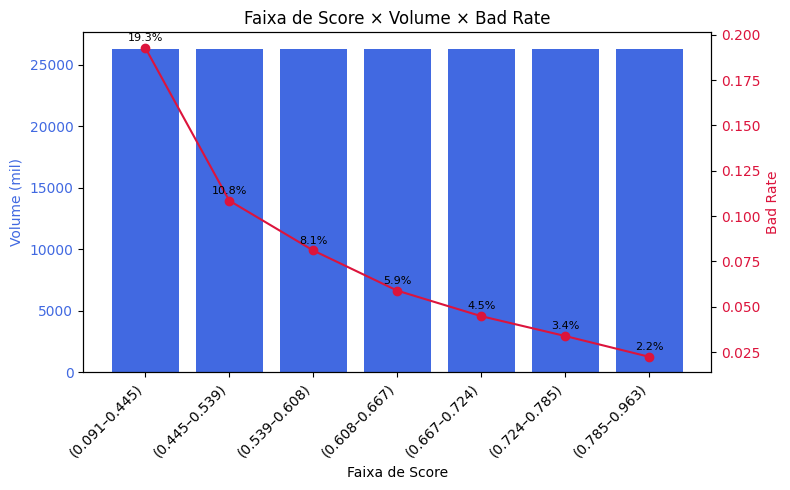

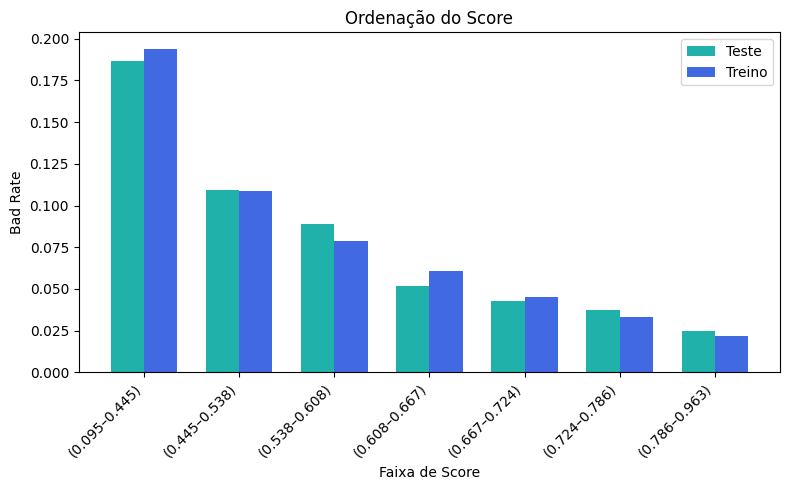

,Métrica,Treino,Teste,Geral
0,AUC,0.707203,0.698528,0.705455
1,Gini,0.414405,0.397057,0.410911
2,KS,0.305844,0.306423,0.304960


In [ ]:
metrics, tabela_treino, tabela_teste, tabela_geral = funcs_deriv.calculate_metrics_final(df_final)

metrics

In [ ]:
tabela_geral

,faixa_str,min_score,max_score,event_rate,volume,lim_inf
0,(0.785–0.963),0.785430,0.963105,0.022365,26336,0.785430
1,(0.724–0.785),0.723688,0.785430,0.033832,26336,0.723688
2,(0.667–0.724),0.667339,0.723686,0.044769,26335,0.667339
3,(0.608–0.667),0.608059,0.667337,0.058855,26336,0.608059
4,(0.539–0.608),0.538701,0.608053,0.080995,26335,0.538701
5,(0.445–0.539),0.444656,0.538699,0.108483,26336,0.444656
6,(0.091–0.445),0.091888,0.444648,0.192778,26336,0.091888


In [ ]:
tabela_treino

,faixa_str,min_score,max_score,event_rate,volume,lim_inf
0,(0.786–0.963),0.785501,0.963105,0.021786,21069,0.785501
1,(0.724–0.786),0.723756,0.785500,0.032893,21068,0.723756
2,(0.667–0.724),0.667413,0.723755,0.045375,21069,0.667413
3,(0.608–0.667),0.608035,0.667412,0.060471,21068,0.608035
4,(0.538–0.608),0.538269,0.608033,0.078551,21069,0.538269
5,(0.445–0.538),0.444574,0.538269,0.108838,21068,0.444574
6,(0.095–0.445),0.096193,0.444562,0.194172,21069,0.096193


In [ ]:
tabela_teste

,faixa_str,min_score,max_score,event_rate,volume,lim_inf
0,(0.785–0.946),0.785043,0.946007,0.024872,5267,0.785043
1,(0.723–0.785),0.723341,0.785042,0.037593,5267,0.723341
2,(0.667–0.723),0.667081,0.723337,0.042529,5267,0.667081
3,(0.608–0.667),0.608198,0.667077,0.052022,5267,0.608198
4,(0.540–0.608),0.540215,0.608180,0.088665,5267,0.540215
5,(0.445–0.540),0.445412,0.540199,0.109550,5267,0.445412
6,(0.091–0.445),0.091888,0.445411,0.186788,5268,0.091888


## 09. Salvando a base do modelo

In [ ]:
df_final.head()

,SK_ID_CURR,TARGET,num__INCOME_TO_BIRTH_RATIO_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_ID_PUBLISH_publico,num__CREDIT_TO_GOODS_RATIO_publico,num__DAYS_REGISTRATION_publico,num__DAYS_LAST_PHONE_CHANGE_publico,num__DAYS_BIRTH_publico,num__DAYS_EMPLOYED_publico,...,num__REGION_RATING_CLIENT_W_CITY_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__CAR_TO_EMPLOYED_RATIO_publico,num__TOTALAREA_MODE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,periodo,score,prob0,prob1,predito
0,100010,0,-19.10,1530000.0,-2379.0,1.00,-4597.0,-1070.0,-18850.0,-449.0,...,3.0,-999.0,-0.02,-999.0000,-999.0,treino,675,0.674962,0.325038,0
1,100263,0,-4.60,585000.0,-4483.0,1.00,-2267.0,-2255.0,-23456.0,365243.0,...,2.0,133240.5,-999.00,0.0645,0.0,treino,791,0.790655,0.209345,0
2,100320,0,-18.76,463500.0,-4623.0,1.04,-2562.0,-842.0,-11996.0,-2907.0,...,2.0,-999.0,0.00,-999.0000,44203.5,treino,707,0.706704,0.293296,0
3,100704,0,-5.06,760500.0,-1291.0,1.00,-6650.0,-196.0,-17781.0,-7042.0,...,2.0,29682.0,-999.00,-999.0000,-999.0,treino,731,0.731402,0.268598,0
4,100768,0,-5.50,229500.0,-3991.0,1.21,-10241.0,-1643.0,-20438.0,-2271.0,...,2.0,-999.0,-0.01,0.0035,-999.0,treino,769,0.769192,0.230808,0


In [ ]:
## Salvar a base de teste em parquet
df_final.to_parquet(r'D:\projeto_modelo_credito\dados\df_final_modelo_lgbm_sem_score.parquet', engine='pyarrow', index=False)

In [ ]:
# Baixando a base salva
df_lgbm = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_final_modelo_lgbm_sem_score.parquet',
                                 engine='pyarrow')
df_lgbm.head()

,SK_ID_CURR,TARGET,num__INCOME_TO_BIRTH_RATIO_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_ID_PUBLISH_publico,num__CREDIT_TO_GOODS_RATIO_publico,num__DAYS_REGISTRATION_publico,num__DAYS_LAST_PHONE_CHANGE_publico,num__DAYS_BIRTH_publico,num__DAYS_EMPLOYED_publico,...,num__REGION_RATING_CLIENT_W_CITY_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__CAR_TO_EMPLOYED_RATIO_publico,num__TOTALAREA_MODE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,periodo,score,prob0,prob1,predito
0,100010,0,-19.10,1530000.0,-2379.0,1.00,-4597.0,-1070.0,-18850.0,-449.0,...,3.0,-999.0,-0.02,-999.0000,-999.0,treino,675,0.674962,0.325038,0
1,100263,0,-4.60,585000.0,-4483.0,1.00,-2267.0,-2255.0,-23456.0,365243.0,...,2.0,133240.5,-999.00,0.0645,0.0,treino,791,0.790655,0.209345,0
2,100320,0,-18.76,463500.0,-4623.0,1.04,-2562.0,-842.0,-11996.0,-2907.0,...,2.0,-999.0,0.00,-999.0000,44203.5,treino,707,0.706704,0.293296,0
3,100704,0,-5.06,760500.0,-1291.0,1.00,-6650.0,-196.0,-17781.0,-7042.0,...,2.0,29682.0,-999.00,-999.0000,-999.0,treino,731,0.731402,0.268598,0
4,100768,0,-5.50,229500.0,-3991.0,1.21,-10241.0,-1643.0,-20438.0,-2271.0,...,2.0,-999.0,-0.01,0.0035,-999.0,treino,769,0.769192,0.230808,0


## 11. Salvando o pickle do modelo

In [ ]:
pickle.dump(model, open('modelo_lightgbm_concessao_sem_score.pkl', 'wb'))